# Data Analysis Notebook

This notebook contains code for an interactive GUI that can run the lick detection algorithm and display results. It is based on the MATLAB lickDetector.m script, and all code for the analysis algorithms is contained in data_analysis.py.

## Initial Setup

### Imports

In [1]:
import os
import re
import glob
from datetime import datetime
import h5py
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

# Widget stuff
#import ipywidgets as widgets
import panel as pn
pn.extension()

# Plotting
import matplotlib.pyplot as plt

# Lick detection algorithm
from data_analysis import filter_data

### Load data

#### Experimental Parameters

In [3]:
# Experimental Parameters
# Base directory that contains one folder per cohort (e.g., Lickometry Data/AEW2, Lickometry Data/AEW3, ...)
base_dir = "Lickometry Data"

# List all cohorts to include in this run
animal_id_prefixes = ["AEW4", "AEW5", "AEW6"]  # <-- edit as needed

# Resolve cohort directories
cohort_dirs = {p: os.path.join(base_dir, p) for p in animal_id_prefixes}

# The recordings will be truncated to the start/stop times, then further trimmed at the end to be exactly
# in accordance with this recording length parameter
recording_length = 2 * 60 * 60  # 2 hours in seconds


In [4]:
# Load layout files for each cohort (assumes each cohort folder contains layout.csv)
layouts = {
    p: pd.read_csv(os.path.join(cohort_dirs[p], "layout.csv"), header=None, index_col=0)
    for p in animal_id_prefixes
}

# Union of all animal IDs across cohorts (columns in the final combined correlation)
all_animal_ids = sorted({row[0] for df in layouts.values() for row in df.values})


In [5]:
# File picker GUI for selecting raw data files across multiple cohorts
file_selectors = {
    p: pn.widgets.FileSelector(
        directory=cohort_dirs[p],
        only_files=True,
        file_pattern="*.h5",
    )
    for p in animal_id_prefixes
}

def get_selected_files():
    files = []
    for _fs in file_selectors.values():
        files.extend(list(_fs.value))
    # preserve a deterministic ordering
    return sorted(set(files))

pn.Column(
    "Select raw data files (you can select files in multiple cohorts using the tabs below). "
    "Use the '>>' button to add file(s) to the processing list. "
    "Later cells read the current selections via get_selected_files().",
    pn.Tabs(*[(p, fs) for p, fs in file_selectors.items()]),
)


Column
    [0] Markdown(str)
    [1] Tabs
        [0] FileSelector(directory='/Users/christopher/TimmeL..., file_pattern='*.h5', only_files=True, root_directory='/Users/christopher/TimmeL...)
        [1] FileSelector(directory='/Users/christopher/TimmeL..., file_pattern='*.h5', only_files=True, root_directory='/Users/christopher/TimmeL...)
        [2] FileSelector(directory='/Users/christopher/TimmeL..., file_pattern='*.h5', only_files=True, root_directory='/Users/christopher/TimmeL...)

### Start/Stop Times Visualization
If the script gives any warnings about start and stop times while running the analysis, it can be useful to plot the traces with start/stop times labeled. Then you can create time_fix.xlsx in the data directory to override the start/stop times stored in the raw data files.

Total recording length: 7641.752587795258 seconds (127.36254312992097 minutes)


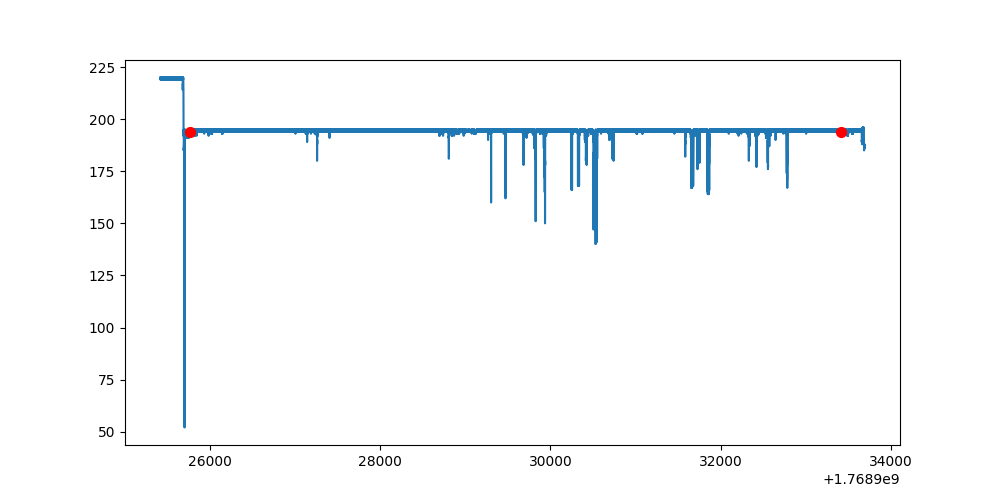

In [10]:
# Time fixes
#   An excel sheet can be used if there are errors in the start
#   and stop times. The user will be able to override the start/stop times
#   recorded and use the capacitance traces to identify start and stop
#   times. This file will have three columns, with headers:
#   Sensor, New Start Time, New End Time. The code will produce
#   plots for the user and data tips can be used identify new start and
#   stop times. The time fix file should be named the same base filename as
#   the corresponding raw data, but with _time_fix.xlsx at the end (so
#   raw_data_2026-01-20_11-10-18.h5 corresponds to
#   raw_data_2026-01-20_11-10-18_time_fix.xlsx). Example time fix file format:
#
#   Sensor    New Start Time      New End Time
#   20        1756825855          1756833056
#   2         1757083015          1757090258
#
#   This would be time fixes for two recordings.
#
# To plot a capacitive trace, change the change the filename listed and the sensor number,
# then re-run this cell. This is useful for determining start/stop times for the file.
# The matplotlib widget backend has been enabled so that you can move around the graph and zoom.
#
# In general, this step can be skipped until a problem is encountered. The automated analysis will
# account for accidental start/stops and use the last start_time/stop_time pair in the file. However,
# if no start or stop time is recorded, this can be used to fix that situation.
file = os.path.join(data_dir, "raw_data_2026-01-20_11-10-18.h5")
sensor = 1

# Determine which board did the recording based on sensor number
match sensor:
    case (1 | 2 | 3 | 7 | 8 | 9):
        board = 0
    case (4 | 5 | 6 | 10 | 11 | 12):
        board = 1
    case (13 | 14 | 15 | 19 | 20 | 21):
        board = 2
    case (16 | 17 | 18 | 22 | 23 | 24):
        board = 3

with h5py.File(file, 'r') as h5f:
    sensor_data = h5f[f'board_FT232H{board}'][f'sensor_{sensor}']
    cap_data = sensor_data['cap_data'][()]
    time_data = sensor_data['time_data'][()]

    # Determine which start time keys we have
    pattern = re.compile(r'^start_time(\d+)?$')
    matches = {}
    for k in sensor_data.keys():
        m = pattern.match(k)
        if m:
            num = int(m.group(1)) if m.group(1) else -1
            matches[num] = k
    if matches:
        num = -np.inf
        for n in matches.keys():
            if n > num: num = n
        last_start = matches[num]
        start_time = sensor_data[last_start][()]
        # Try the stop_time corresponding to the start_time above
        try:
            stop_time = sensor_data['stop' + last_start[5:]][()]
        except KeyError:
            # Stop time wasn't recorded (likely clicked stop all button too soon)
            stop_time = time_data[-1]
    else: # no start time recorded
        start_time = time_data[0] # start at beginning
        stop_time = time_data[-1] # stop at end    

total_recording_time = stop_time - start_time
print(f"Total recording length: {total_recording_time} seconds ({total_recording_time/60} minutes)")
start_idx = np.argmin(
    np.abs(time_data - start_time)
)
stop_idx = np.argmin(
    np.abs(time_data - stop_time)
)

%matplotlib widget
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time_data, cap_data, zorder=0)
ax.scatter(start_time, cap_data[start_idx], marker='o', c='r', s=50, zorder=1)
ax.scatter(stop_time, cap_data[stop_idx], marker='o', c='r', s=50, zorder=2)

## Run Analysis

In [8]:
# Loop through selected data files (across cohorts) and run the filter_data script on them
selected_files = get_selected_files()

missing_data_files = []
for raw_data_filename in selected_files:
    print(f"Working on file: {raw_data_filename}")

    # Infer cohort prefix from the parent directory name (expects .../<PREFIX>/<raw_file>.h5)
    prefix = os.path.basename(os.path.dirname(raw_data_filename))
    if prefix not in layouts:
        raise ValueError(f"Cannot infer cohort prefix for file: {raw_data_filename} (got prefix='{prefix}').")

    layout = layouts[prefix]

    raw_data_filename_base = os.path.basename(raw_data_filename)
    filtered_data_filename_base = "filtered" + raw_data_filename_base[3:]
    filtered_data_filename = os.path.join(os.path.dirname(raw_data_filename), filtered_data_filename_base)

    time_fix_filename = raw_data_filename[:-3] + "_time_fix.xlsx"

    with h5py.File(raw_data_filename, 'r') as raw_h5, h5py.File(filtered_data_filename, 'w') as filtered_h5:
        try:
            print(f"Comments from current raw data file:")
            print(raw_h5['comments'][()] + "\n")
        except KeyError:
            print("No comments in metadata\n")

        # Check if there's a corresponding time fix file and pass it, if so
        if os.path.exists(time_fix_filename):
            missing_data = filter_data(
                raw_h5,
                filtered_h5,
                layout,
                raw_data_filename[:-3] + '.log',
                time_fix=pd.read_excel(time_fix_filename, index_col=False, header=0),
                algorithm="basic_threshold",
            )
        else:
            missing_data = filter_data(
                raw_h5,
                filtered_h5,
                layout,
                raw_data_filename[:-3] + '.log',
                algorithm="basic_threshold",
            )

    if missing_data:
        missing_data_files.append(raw_data_filename)
        print(f"Skipping file {raw_data_filename} due to missing data\n")
    else:
        print("")  # newline between files

# Keep only files that had complete data
selected_files = [f for f in selected_files if f not in set(missing_data_files)]


Working on file: /Users/christopher/TimmeLab/Capacitive-Lick-Detection/Lickometry Data/AEW4/raw_data_2025-09-01_10-57-58.h5
Comments from current raw data file:
No comments in metadata

Animal AEW4-1 had 322 licks detected
Animal AEW4-2 had 107 licks detected
Animal AEW4-3 had 85 licks detected
Animal AEW4-4 had 370 licks detected
Animal AEW4-5 had 563 licks detected
Animal AEW4-6 had 112 licks detected
Animal AEW4-7 had 218 licks detected
Animal AEW4-8 had 86 licks detected
Animal AEW4-9 had 302 licks detected
Animal AEW4-10 had 167 licks detected
Animal AEW4-11 had 41 licks detected
Animal AEW4-12 had 135 licks detected
Animal AEW4-13 had 380 licks detected
Animal AEW4-14 had 98 licks detected
Animal AEW4-15 had 64 licks detected
Animal AEW4-16 had 109 licks detected
Animal AEW4-17 had 152 licks detected
Animal AEW4-18 had 381 licks detected
Animal AEW4-19 had 151 licks detected
Animal AEW4-20 had 76 licks detected

Working on file: /Users/christopher/TimmeLab/Capacitive-Lick-Detecti

## Combine Results by Animal

In [9]:
# Get the dates of the raw data files, so we can get a list of dates analyzed to put in the combined filename
dates = []
date_range = []
pattern = r'raw_data_(\d{4}-\d{2}-\d{2})_'
for raw_data_filename in selected_files:
    match = re.search(pattern, os.path.basename(raw_data_filename))
    if match:
        dates.append(match.group(1))

# Sort files/dates together by date to keep indexing consistent downstream
if dates:
    date_pairs = sorted(zip(dates, selected_files), key=lambda x: x[0])
    dates, selected_files = map(list, zip(*date_pairs))


In [10]:
# Parse the dates and create a compact date-range string for the combined filename
parsed = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

year_tmp = parsed[0].year
month_tmp = parsed[0].month

# Add the first date in full to the date range
date_range.append(parsed[0].strftime("%Y-%m-%d"))
for date in parsed[1:]:
    # Same month and year
    if date.year == year_tmp and date.month == month_tmp:
        date_range.append(date.strftime("%d"))
    elif date.year == year_tmp:
        month_tmp = date.month
        date_range.append(date.strftime("%m-%d"))
    else:
        year_tmp = date.year
        month_tmp = date.month
        date_range.append(date.strftime("%Y-%m-%d"))

# Join the dates to a string for the combined filename
date_range = "_".join(date_range)

# Combined filename includes all cohort prefixes
prefix_str = "-".join(animal_id_prefixes)
combined_filename = f"results_combined_{prefix_str}_{date_range}.h5"
combined_filepath = os.path.join(base_dir, combined_filename)


In [11]:
# Combine results into a single H5 file grouped by animal_id, with a subgroup per input file (indexed by file number)

# Precompute file -> cohort prefix mapping (expects .../<PREFIX>/<raw_file>.h5)
file_info = []
for f in selected_files:
    prefix = os.path.basename(os.path.dirname(f))
    if prefix not in layouts:
        raise ValueError(f"Cannot infer cohort prefix for file: {f} (got prefix='{prefix}').")
    file_info.append((f, prefix))

# Re-create combined file each run
with h5py.File(combined_filepath, 'w') as out_h5:
    # Create top-level groups (one per animal across all cohorts)
    for animal_id in all_animal_ids:
        out_h5.create_group(animal_id)

    # Populate per-file subgroups only for animals present in that cohort
    for i, (raw_data_filename, prefix) in enumerate(file_info):
        raw_data_filename_base = os.path.basename(raw_data_filename)
        filtered_data_filename_base = "filtered" + raw_data_filename_base[3:]
        filtered_data_filename = os.path.join(os.path.dirname(raw_data_filename), filtered_data_filename_base)

        cohort_animal_ids = [row[0] for row in layouts[prefix].values]

        with h5py.File(filtered_data_filename, 'r') as in_h5:
            for animal_id in cohort_animal_ids:
                if animal_id not in in_h5:
                    continue  # animal missing from this file
                # Create subgroup for this file index under this animal
                grp = out_h5[animal_id]
                grp2 = grp.create_group(str(i))

                try:
                    grp2.create_dataset('weights', data=in_h5[animal_id]['weight'][()])
                    grp2.create_dataset('consumed_vols', data=in_h5[animal_id]['consumed_vol'][()])
                except KeyError:
                    # If weight or volume consumed wasn't properly recorded, skip this animal/file entry
                    # (but keep others)
                    del grp[str(i)]
                    continue

                grp2.create_dataset('lick_indices', data=in_h5[animal_id]['lick_indices'][()])
                grp2.create_dataset('lick_times', data=in_h5[animal_id]['lick_times'][()])
                grp2.create_dataset('cap_data', data=in_h5[animal_id]['cap_data'][()])
                grp2.create_dataset('time_data', data=in_h5[animal_id]['time_data'][()])
                grp2.create_dataset('used_start_idx', data=in_h5[animal_id]['used_start_idx'][()])
                grp2.create_dataset('used_stop_idx', data=in_h5[animal_id]['used_stop_idx'][()])


### Remove Intermediate Files

In [12]:
# Remove intermediate filtered_*.h5 files from all cohort folders (optional)
for p in animal_id_prefixes:
    for f in glob.glob(os.path.join(cohort_dirs[p], "filtered_*.h5")):
        os.remove(f)


## Visualization

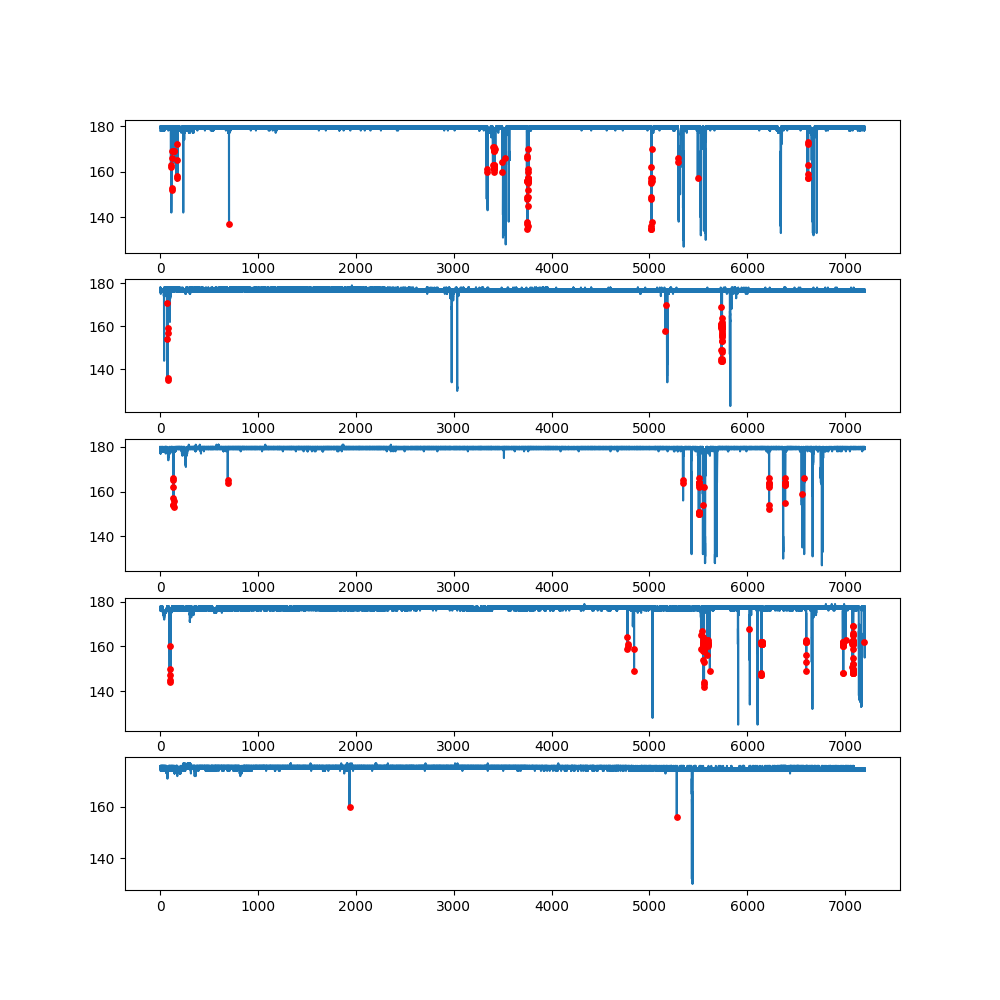

In [14]:
# Select the animal of interest and this cell will plot the full
# capacitive trace and place a red dot on each detected lick.
# This assumes you've selected raw data files and run the analysis so the corresponding
# results_combined...h5 file exists and has its filename stored in combined_filename.

animal_id = "AEW4-3"  # <-- set an explicit animal ID, e.g. "AEW5-12"

with h5py.File(combined_filepath, 'r') as h5f:
    animal_data = h5f[animal_id]
    cap_data = {}
    time_data = {}
    lick_indices = {}
    for grp_num, grp_data in animal_data.items():
        grp_num = int(grp_num)
        cap_data[grp_num] = grp_data['cap_data'][()]
        time_data[grp_num] = grp_data['time_data'][()]
        lick_indices[grp_num] = grp_data['lick_indices'][()]

%matplotlib widget
fig, ax = plt.subplots(nrows=len(cap_data), figsize=(10, 10))
for i in range(len(cap_data)):
    ax[i].plot(time_data[i], cap_data[i], zorder=0)
    ax[i].scatter(time_data[i][lick_indices[i]], cap_data[i][lick_indices[i]], marker='o', c='r', s=15, zorder=1)
plt.show()


## Correlation

In [15]:
# Gather arrays n_licks and vol_consumed (shape: n_files x n_animals) for correlation
n_animals = len(all_animal_ids)
n_files = len(selected_files)

n_licks = np.full((n_files, n_animals), np.nan, dtype=float)
vol_consumed = np.full((n_files, n_animals), np.nan, dtype=float)

with h5py.File(combined_filepath, 'r') as h5f:
    for a_idx, animal_id in enumerate(all_animal_ids):
        if animal_id not in h5f:
            continue
        animal_data = h5f[animal_id]
        for grp_num, grp_data in animal_data.items():
            grp_num = int(grp_num)
            if grp_num >= n_files:
                continue
            # consumed_vols is a scalar; lick_indices is a variable-length array
            vol_consumed[grp_num, a_idx] = grp_data['consumed_vols'][()]
            n_licks[grp_num, a_idx] = grp_data['lick_indices'][()].size


In [16]:
# Helper functions to replicate some MATLAB behavior from lickDetector.m
def mad_based_outliers(r, thresh=3.0):
    """
    Like MATLAB isoutlier, based on median absolute deviation
    Flag points where |r - median(r)| > thresh * (1.4826 * MAD).
    """
    r = np.asarray(r, dtype=float)
    med = np.median(r)
    mad = np.median(np.abs(r - med))
    if mad == 0:
        return np.zeros_like(r, dtype=bool)
    sigma = 1.4826 * mad # from definition of MAD
    return np.abs(r - med) > thresh * sigma


def linear_index_to_row_col(idx0, n_files):
    """
    MATLAB code:
        exclude = [ceil(outlier/nFiles), rem(outlier,nFiles)];
        exclude(exclude(:,2) == 0,2) = nFiles;
    where outlier is 1-based.

    Here idx0 is 0-based. Returns (row0, col0) 0-based indices matching
    data[row][col][...].
    """
    col0 = idx0 // n_files
    row0 = idx0 % n_files
    return row0, col0


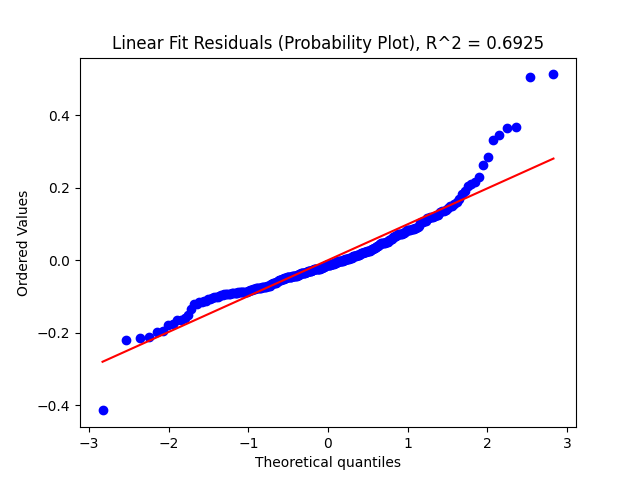

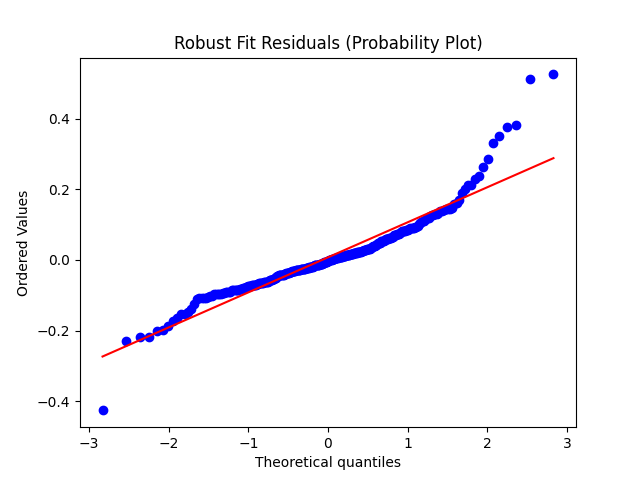

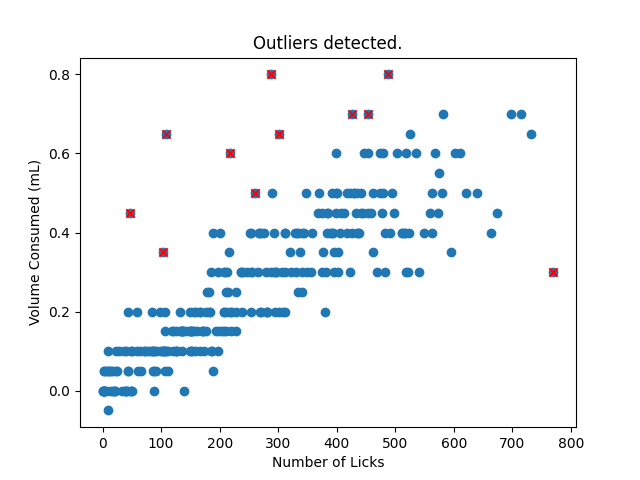

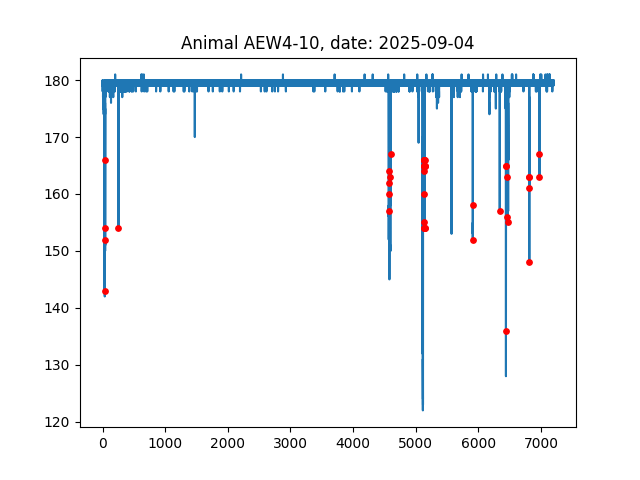

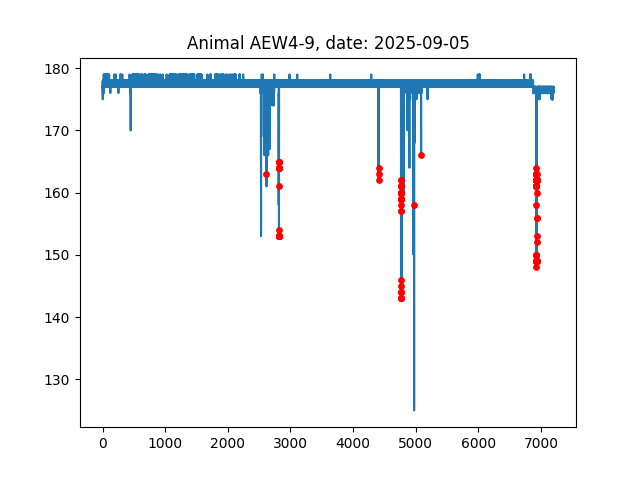

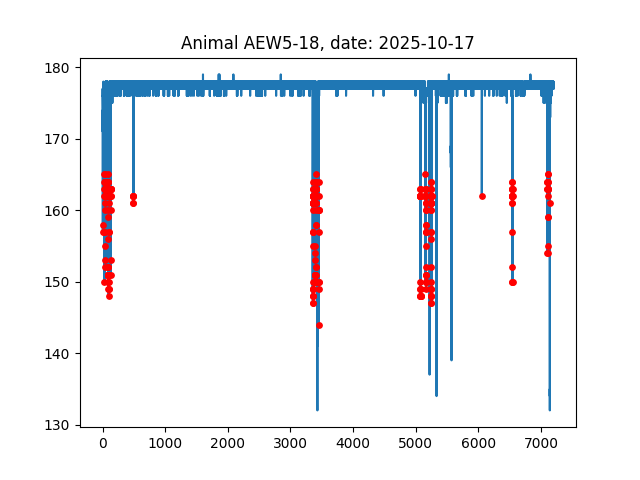

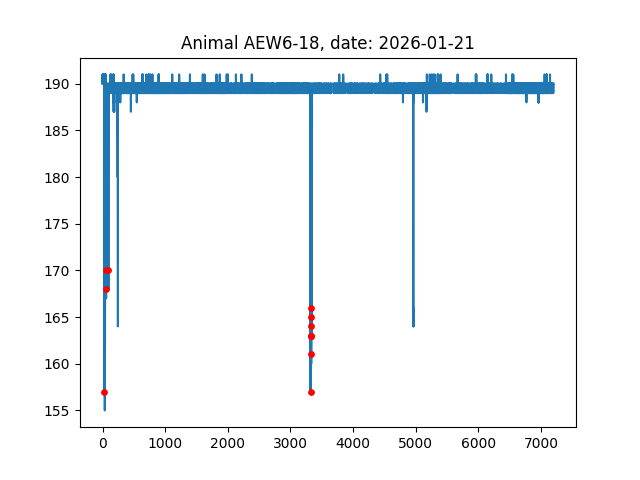

In [17]:
# Linear model (OLS)
X = sm.add_constant(n_licks.ravel())
y = vol_consumed.ravel()
mdl = sm.OLS(y, X, missing='drop').fit()

# Robust linear model (RLM)
mdlr = sm.RLM(y, X, M=sm.robust.norms.HuberT(), missing='drop').fit()

# Residuals from robust fit (raw residuals)
yhat_r = mdlr.predict(X)
resid_r = y - yhat_r

# Residual probability plots
plt.figure()
stats.probplot(mdl.resid, dist="norm", plot=plt)
plt.title(f"Linear Fit Residuals (Probability Plot), R^2 = {mdl.rsquared:.4f}")

plt.figure()
stats.probplot(resid_r[~np.isnan(resid_r)], dist="norm", plot=plt)
plt.title("Robust Fit Residuals (Probability Plot)")

# Detect outliers in robust residuals
# Note: resid_r may include NaNs if some animal/file entries were missing; drop them for outlier detection.
valid_mask = ~np.isnan(resid_r)
resid_valid = resid_r[valid_mask]
is_out = mad_based_outliers(resid_valid, thresh=3.0)
outlier_idx_valid0 = np.flatnonzero(is_out)  # indices into resid_valid

# Map back to indices into the flattened full arrays
flat_valid_idx0 = np.flatnonzero(valid_mask)
outlier_idx0 = flat_valid_idx0[outlier_idx_valid0]

# Show outliers to the user
if outlier_idx0.size > 0:
    plt.figure()
    plt.scatter(n_licks.ravel(), y)
    plt.scatter(n_licks.ravel()[outlier_idx0], y[outlier_idx0], marker="x", c="r")
    plt.title("Outliers detected.")
    plt.xlabel("Number of Licks")
    plt.ylabel("Volume Consumed (mL)")

    # Reorganize outlier info into (row, col) indices for data access
    # Here, col0 indexes all_animal_ids, row0 indexes selected_files
    exclude = np.array([linear_index_to_row_col(i, n_files) for i in outlier_idx0], dtype=int)

    # Plot capacitance traces for excluded channel-days
    with h5py.File(combined_filepath, 'r') as h5f:
        for row0, col0 in exclude:
            file_num = row0
            animal_id = all_animal_ids[col0]

            # Some entries may not exist (e.g., missing data); skip if so
            if animal_id not in h5f:
                continue
            animal_data = h5f[animal_id]
            if str(file_num) not in animal_data:
                continue

            single_day_data = animal_data[str(file_num)]

            plt.figure()
            t = single_day_data['time_data'][()]
            v = single_day_data['cap_data'][()]
            lick_indices = single_day_data['lick_indices'][()]
            plt.plot(t, v, zorder=0)
            plt.scatter(t[lick_indices], v[lick_indices], marker='o', c='r', s=15, zorder=1)
            plt.title(f"Animal {animal_id}, date: {dates[file_num]}")
